In [1]:
from dynamics import *
from problem import *
import numpy as np
from casadi import *
import matplotlib.pyplot as plt
import seaborn as sns
from util import *
import itertools 
from time import perf_counter

In [2]:
%load_ext autoreload
%autoreload 2

## An example of using Casadi to optimize trajectory for a single quadrotor:

In [17]:
# x0 = np.random.rand(6*3,1)
x0 = np.array([0.1, 0.1, 1.0, 0.1, 0.1, 0.1])
xf = np.array([1.2, 1.2, 1.8, 0, 0, 0])
Q = np.diag([5,5,5,1,1,1])
R = np.eye(3)*0.01
Qf = np.eye(6)*1000
g = 9.8

u_ref = np.array([0,0,g])
N = 100

opti = Opti()

dt = 0.05

In [18]:
# models = [quad6D,quad6D,quad6D]

In [19]:
# ids = [i for i in range(n_agents)]

In [20]:
# quad6D(xf,Q,R,Qf,u_ref,N).cost()

In [21]:
# dynamics = MultiDynamicalModel([model(split_agents(xf.T,x_dims)[id_],Q,R,Qf,split_agents(u_ref.T,u_dims)[id_],N) for model,id_ in zip(models,ids)])

In [22]:
# problem = quadProblem()

In [23]:
X = opti.variable(6,N+1)
U = opti.variable(3,N)

In [24]:
# x_dims = [6,6,6,6]

In [25]:
g = 9.81

In [26]:
f = lambda x,u: vertcat(x[3],x[4],x[5],g*tan(u[0]),-g*tan(u[1]),u[2]-g) #dx/dt = f(x,u)

In [27]:
for k in range(N): #loop over control intervals
    # Runge-Kutta 4 integration
    k1 = f(X[:,k],         U[:,k])
    k2 = f(X[:,k]+dt/2*k1, U[:,k])
    k3 = f(X[:,k]+dt/2*k2, U[:,k])
    k4 = f(X[:,k]+dt*k3,   U[:,k])
    x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4) 

    opti.subject_to(X[:,k+1]==x_next) # close the gaps


In [28]:
total_stage_cost = 0
for j in range(X.shape[1]-1):
    for i in range(X.shape[0]):
        total_stage_cost += (X[i,j]-xf[i])*Q[i, i]*(X[i,j]-xf[i])

for j in range(U.shape[1]-1):
    for i in range(U.shape[0]):
        total_stage_cost += (U[i,j]-u_ref[i])*R[i, i]*(U[i,j]-u_ref[i])

#Quadratic terminal cost:
total_terminal_cost = 0
# for j in range(X.shape[1]):
for i in range(X.shape[0]):
    total_terminal_cost += (X[i,-1]-xf[i])*Qf[i, i]*(X[i,-1]-xf[i])

In [29]:
objective = total_terminal_cost + total_stage_cost
# objective = total_stage_cost


In [30]:
opti.minimize(objective) 

In [31]:
opti.subject_to(X[2,:]<=3.0) # altitude p_z is limited
opti.subject_to(0.4<=X[2,:])

opti.subject_to(X[0,:]<=3) # p_x is limited
opti.subject_to(-3<=X[0,:])

opti.subject_to(X[1,:]<=3) # p_y is limited
opti.subject_to(-3<=X[1,:])

opti.subject_to(U[0,:]<=np.pi/6) # theta is limited
opti.subject_to(-np.pi/6<=U[0,:])

opti.subject_to(U[1,:]<=np.pi/6) # phi is limited
opti.subject_to(-np.pi/6<=U[1,:])

opti.subject_to(U[2,:]<=25) # tau is limited
opti.subject_to(0<=U[2,:]) #minimum force 

# opti.subject_to(X[0:3,-1] == xf[0:3])
#equality constraints:
opti.subject_to(X[:,0] == x0)
t0 = perf_counter()
opti.solver("ipopt")
sol = opti.solve()
tf = perf_counter()

print(f'total run time is {tf-t0} seconds')


This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     2106
Number of nonzeros in inequality constraint Jacobian.:     1206
Number of nonzeros in Lagrangian Hessian.............:      905

Total number of variables............................:      906
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      606
Total number of inequality constraints...............:     1206
        inequality constraints with only lower bounds:      603
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      603

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.2750796e+03 1.00e+00 2.19e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [32]:
X_trj = sol.value(X)
U_trj = sol.value(U)

In [33]:
U_trj.shape

(3, 100)

Text(0.5, 0.92, 'Trajectory from one-shot optimization')

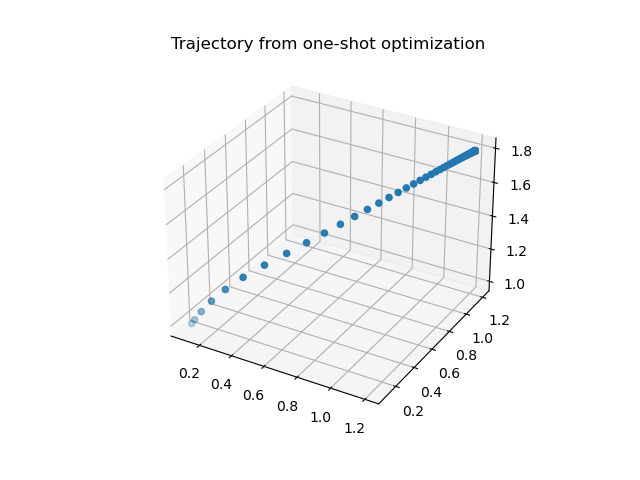

In [34]:
%matplotlib ipympl
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X_trj[0,:],X_trj[1,:],X_trj[2,:])
ax.set_title('Trajectory from one-shot optimization')


In [35]:
pos_err = np.linalg.norm(X_trj[0:3,-1]-xf[0:3])
pos_err

5.2727072380359054e-06

## Running the above optimizaiton but in a receding-horizon fashion:
In this case, we relax the terminal state constraint and impose a terminal state cost into the objective function. The reason is that each optimization step is solved over a control horizon, and it's not possible that the drone reaches its goal after each control horizon (which keeps shifting forward)

In [8]:
def objective(X,U,u_ref,xf,Q,R,Qf):
    total_stage_cost = 0
    for j in range(X.shape[1]-1):
        for i in range(X.shape[0]):
            total_stage_cost += (X[i,j]-xf[i])*Q[i, i]*(X[i,j]-xf[i])

    for j in range(U.shape[1]-1):
        for i in range(U.shape[0]):
            total_stage_cost += (U[i,j]-u_ref[i])*R[i, i]*(U[i,j]-u_ref[i])

    #Quadratic terminal cost:
    total_terminal_cost = 0

    for i in range(X.shape[0]):
        total_terminal_cost += (X[i,-1]-xf[i])*Qf[i, i]*(X[i,-1]-xf[i])
            
    return total_stage_cost + total_terminal_cost
    # return total_stage_cost

In [37]:
x0 = np.array([0.5, 0.5, 1.0, 0.0, 0.0, 0.0])
xf = np.array([1.3, 1.1, 1.8, 0, 0, 0])
Q = np.diag([5,5,5,1,1,1])
R = np.eye(3)*0.01
Qf = np.eye(6)*1000

# u_ref = np.zeros((3,1))
u_ref = np.array([0,0,9.8])

In [38]:
n_agents = 1
n_states = 6
n_inputs=  3

In [39]:
def solve_rhc(x0,xf,u_ref,N,Qf):
    #N is the shifting prediction horizon
    
    p_opts = {"expand":True}
    s_opts = {"max_iter": 100,"print_level":4}
    
    opti = Opti()
    M = 100 # this is the entire fixed horizon
 
    n_x = n_agents*n_states
    n_u = n_agents*n_inputs
    
    X_full = np.zeros((0, n_x))
    U_full = np.zeros((0, n_u))
    
    t = 0

    J_list = []
    J_list.append(np.inf)
    # for i in range(M) :
    i = 0
    
    f = lambda x,u: vertcat(x[3],x[4],x[5],g*tan(u[0]),-g*tan(u[1]),u[2]-g) #dx/dt = f(x,u)
    
    dt = 0.05
    
    while (np.linalg.norm(x0[0:3]-xf[0:3]) > 0.1) and (i < M):
    
        X = opti.variable(6,N+1)
        U = opti.variable(3,N)
        
        cost_fun = objective(X,U,u_ref,xf,Q,R,Qf)
        opti.minimize(cost_fun)
        
        for k in range(N): #loop over control intervals
            # Runge-Kutta 4 integration
            k1 = f(X[:,k],         U[:,k])
            k2 = f(X[:,k]+dt/2*k1, U[:,k])
            k3 = f(X[:,k]+dt/2*k2, U[:,k])
            k4 = f(X[:,k]+dt*k3,   U[:,k])
            x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4) 

            opti.subject_to(X[:,k+1]==x_next) # close the gaps

        opti.subject_to(X[2,:]<=3.0) # altitude p_z is limited
        opti.subject_to(0.4<=X[2,:])

        opti.subject_to(X[0,:]<=3) # p_x is limited
        opti.subject_to(-3<=X[0,:])

        opti.subject_to(X[1,:]<=3) # p_y is limited
        opti.subject_to(-3<=X[1,:])

        opti.subject_to(U[0,:]<=np.pi/6) # theta is limited
        opti.subject_to(-np.pi/6<=U[0,:])

        opti.subject_to(U[1,:]<=np.pi/6) # phi is limited
        opti.subject_to(-np.pi/6<=U[1,:])

        opti.subject_to(U[2,:]<=20) # tau is limited
        opti.subject_to(0<=U[2,:]) #minimum force keeps the drone at hover

        #equality constraints for initial condition:
        opti.subject_to(X[:,0] == x0)

        
        opti.solver("ipopt",p_opts,
                    s_opts) 
        
        
        sol = opti.solve()
        x0 = sol.value(X)[:,1]
        u_sol = sol.value(U)[:,0]
        J_list.append(sol.value(cost_fun))
        
        
        #Store the trajectory
        
        X_full = np.r_[X_full, x0.reshape(1,-1)]
        U_full = np.r_[U_full, u_sol.reshape(1,-1)]
        
        t += dt
        i +=1
        
        if abs(J_list[i]-J_list[i-1]) <= 10 :
            print(f'Terminated! at i = {i}')
            break
        
        
    return X_full,U_full, t
    

In [40]:
from time import perf_counter

In [52]:
N = 5
t0 = perf_counter()
x_trj,u_trj, t = solve_rhc(x0,xf,u_ref,N,Qf)
tf = perf_counter()
print(f'total run time is {tf-t0} seconds')

Total number of variables............................:       51
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       36
Total number of inequality constraints...............:       66
        inequality constraints with only lower bounds:       33
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       33


Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:   3.4017142819481876e+01    1.2246171415013475e+03
Dual infeasibility......:   1.1463754370690665e-11    4.1269515734486395e-10
Constraint violation....:   1.5709655798445965e-12    1.5709655798445965e-12
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementari

In [54]:
x_trj.shape

(13, 6)

Text(0.5, 0.92, 'Trajectory with receding horizon')

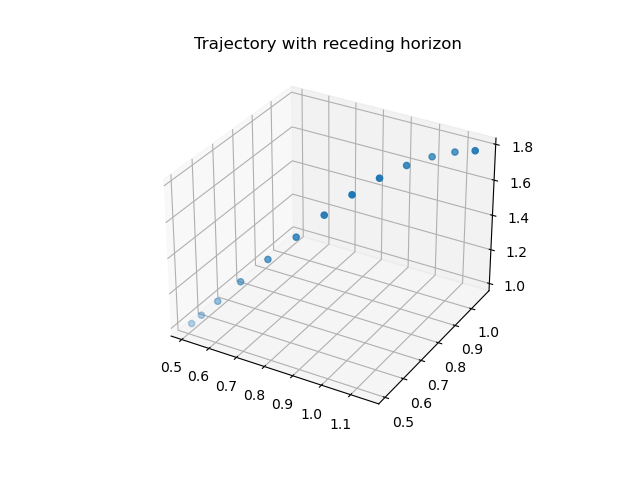

In [55]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(x_trj[:,0],x_trj[:,1],x_trj[:,2])
ax.set_title('Trajectory with receding horizon')

In [56]:
x0

array([0.5, 0.5, 1. , 0. , 0. , 0. ])

In [57]:
xf

array([1.3, 1.1, 1.8, 0. , 0. , 0. ])

In [58]:
pos_err = np.linalg.norm(x_trj[-1,0:3]-xf[0:3])

In [59]:
pos_err  #not bad!


0.15617748624520592

## Running 3 drones in a centralized fashion:

In [33]:
x0,xf = paper_setup_3_quads()

In [34]:
x0 = x0 + np.random.rand(18,1)*0.01

In [35]:
x0

array([[5.09075182e-01],
       [1.50458567e+00],
       [1.00392756e+00],
       [7.07182437e-03],
       [2.81146825e-03],
       [3.87636611e-03],
       [2.50624854e+00],
       [1.50772953e+00],
       [1.00417818e+00],
       [3.10502151e-03],
       [9.78595688e-03],
       [5.08302784e-03],
       [1.50152040e+00],
       [1.30357180e+00],
       [1.00359271e+00],
       [7.00401196e-03],
       [3.80763630e-03],
       [2.09578082e-04]])

In [36]:
g = 9.81

In [37]:
f = lambda x,u: vertcat(x[3],x[4],x[5],  g*tan(u[0]), -g*tan(u[1]),u[2]-g,
                        x[9],x[10],x[11], g*tan(u[3]), -g*tan(u[4]), u[5]-g,
                        x[15],x[16],x[17], g*tan(u[6]), -g*tan(u[7]), u[8]-g) #dx/dt = f(x,u)

In [38]:
n_agents = 3
n_states = 6
n_inputs=  3

dt = 0.1

# Qs = [Q] * n_agents
# Rs = [R] * n_agents
# Qfs = [Qf] * n_agents
# x_dims = [n_states]*n_agents
# u_dims = [n_inputs]*n_agents

In [39]:
u_ref = np.array([0, 0, g, 0, 0, g, 0, 0, g])
Q = np.diag([5,5,5,1,1,1,5,5,5,1,1,1,5,5,5,1,1,1])
R = np.eye(n_agents*n_inputs)*0.01
Qf = np.eye(n_agents*n_states)*1000

In [40]:
def solve_rhc(x0,xf,u_ref,N,Q,R,Qf):
    #N is the shifting prediction horizon
    
    p_opts = {"expand":True}
    s_opts = {"max_iter": 100,"print_level":4}
    
    opti = Opti()
    M = 100 # this is the entire fixed horizon
 
    n_x = n_agents*n_states
    n_u = n_agents*n_inputs
    
    X_full = np.zeros((0, n_x))
    U_full = np.zeros((0, n_u))
    
    t = 0

    J_list = []
    J_list.append(np.inf)
    # for i in range(M) :
    i = 0
    dt = 0.05
    
    while (np.linalg.norm(x0[0:3]-xf[0:3]) > 0.1) and (i < M):
    
        X = opti.variable(n_x,N+1)
        U = opti.variable(n_u,N)
        
        cost_fun = objective(X,U,u_ref,xf,Q,R,Qf)
        opti.minimize(cost_fun)
        
        for k in range(N): #loop over control intervals
            # Runge-Kutta 4 integration
            k1 = f(X[:,k],         U[:,k])
            k2 = f(X[:,k]+dt/2*k1, U[:,k])
            k3 = f(X[:,k]+dt/2*k2, U[:,k])
            k4 = f(X[:,k]+dt*k3,   U[:,k])
            x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4) 

            opti.subject_to(X[:,k+1]==x_next) # close the gaps

        opti.subject_to(X[2,:]<=3.0) # altitude p_z is limited
        opti.subject_to(0.4<=X[2,:])

        opti.subject_to(X[0,:]<=3) # p_x is limited
        opti.subject_to(-3<=X[0,:])

        opti.subject_to(X[1,:]<=3) # p_y is limited
        opti.subject_to(-3<=X[1,:])

        opti.subject_to(U[0,:]<=np.pi/6) # theta is limited
        opti.subject_to(-np.pi/6<=U[0,:])

        opti.subject_to(U[1,:]<=np.pi/6) # phi is limited
        opti.subject_to(-np.pi/6<=U[1,:])

        opti.subject_to(U[2,:]<=20) # tau is limited
        opti.subject_to(0<=U[2,:]) #minimum force keeps the drone at hover

        #equality constraints for initial condition:
        opti.subject_to(X[:,0] == x0)
        
        #Collision avoidance constraints:
        opti.subject_to(-sqrt((X[0,:]-X[6,:])**2+(X[1,:]-X[7,:])**2+(X[2,:]-X[8,:])**2) <= 0.5)
        opti.subject_to(-sqrt((X[0,:]-X[12,:])**2+(X[1,:]-X[13,:])**2+(X[2,:]-X[14,:])**2) <= 0.5)
        opti.subject_to(-sqrt((X[12,:]-X[6,:])**2+(X[13,:]-X[7,:])**2+(X[14,:]-X[8,:])**2) <= 0.5)

        
        opti.solver("ipopt",p_opts,
                    s_opts) 
        
        
        sol = opti.solve()
        x0 = sol.value(X)[:,1]
        u_sol = sol.value(U)[:,0]
        J_list.append(sol.value(cost_fun))
        
        
        #Store the trajectory
        
        X_full = np.r_[X_full, x0.reshape(1,-1)]
        U_full = np.r_[U_full, u_sol.reshape(1,-1)]
        
        t += dt
        i +=1
        
        if abs(J_list[i]-J_list[i-1]) <= 10 :
            print(f'Terminated! at i = {i}')
            break
        
        
    return X_full,U_full, t

In [41]:
N = 5
t0 = perf_counter()
x_trj,u_trj, t = solve_rhc(x0,xf,u_ref,N,Q,R,Qf)
tf = perf_counter()
print(f'total run time is {tf-t0} seconds')

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 1
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT                               = 0.001

EXIT: Invalid number in NLP function or derivative detected.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_g  |        0 (       0)   9.40us (  9.40us)         1
  nlp_grad_f  |        0 (       0

CasADi - 2022-11-28 14:11:56 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 4 (row 174, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-11-28 14:11:56 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 4 (row 174, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-11-28 14:11:56 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 4 (row 174, col 0).") [.../casadi/core/oracle_function.cpp:265]


RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:159:
.../casadi/core/optistack_internal.cpp:997: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Invalid_Number_Detected'

In [42]:
opti.debug.value

NameError: name 'opti' is not defined